In [ ]:
pip install torchtext==0.5.0

In [ ]:
pip install torchtext

In [ ]:
pip show torchtext

Name: torchtext
Version: 0.5.0
Summary: Text utilities and datasets for PyTorch
Home-page: https://github.com/pytorch/text
Author: PyTorch core devs and James Bradbury
Author-email: jekbradbury@gmail.com
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, torch, tqdm, numpy, sentencepiece, requests
Required-by: 


In [ ]:
pip install ekphrasis

In [ ]:
import pandas as pd
import os
import numpy as np
import torch

from torch import nn, optim
from torchtext.data import Field, Dataset, Example, BucketIterator, Iterator, TabularDataset
from tqdm import tqdm, trange

### The two cells below are for manually importing the helper functions

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil 
import os

from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from tensorflow import keras


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def clean_text(data, normalize_list, annotate_list):
        """
        This function preprocesses the text using the Ekphrasis library
        
        data: Pandas series object containing strings of text

        normalize_list: list of data features to clean

        annotate_list: list of data features to annotate
        """

        text_processor = TextPreProcessor(
            normalize= normalize_list,
            annotate= annotate_list,
            fix_html=True,
            segmenter="twitter", 
            unpack_hashtags=True,  
            unpack_contractions=True,  
            spell_correct_elong=True,  
            tokenizer=SocialTokenizer(lowercase=True).tokenize,
            dicts=[emoticons]
        )

        clean_data = data.map(lambda x: " ".join(text_processor.pre_process_doc(x)))

        return clean_data


def early_stopping(val_loss_values, early_stop_vals):
    """
    Determines whether or not the model will keep running based on the patience and delta given relative to the val loss
    """
    if len(val_loss_values) > early_stop_vals["patience"]:
      if val_loss_values[-1] <= np.mean(np.array(val_loss_values[-1-early_stop_vals["patience"]:-1])) - early_stop_vals["delta"]:
        return False
      else:
        return True
    else:
      return False


def training_plot(train_loss_values, val_loss_values):
    """
    Plots loss after each epoch

    training_loss_values: list of floats; output from fine_tune function

    val_loss_values: list of floats; output from fine_tune function
    """
    sns.set(style='darkgrid')
    plt.rcParams["figure.figsize"] = (12,6)

    plt.plot(train_loss_values, 'b-o', label="train")
    plt.plot(val_loss_values, 'g-o', label="valid")

    #plt.title("Training and Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    #plt.savefig("dogwhistle_train_plot.png",bbox_inches='tight')

    return plt.show()


def metrics(labels, preds, argmax_needed: bool = False):
    """
    Returns the Matthew's correlation coefficient, accuracy rate, true positive rate, true negative rate, false positive rate, false negative rate, precission, recall, and f1 score
    
    labels: list of correct labels

    pred: list of model predictions
    """
    labels = labels
    preds = preds

    if argmax_needed == True:
        preds = np.argmax(preds, axis=1).flatten()

    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    f1 = f1_score(labels, preds, average= "weighted")
    precision = precision_score(labels, preds, average= "weighted")
    recall = f1_score(labels, preds, average= "weighted")

    results = {
        "mcc": mcc,
        "acc": acc,
        "confusion_matrix": cm,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    
    return results, labels, preds


def model_saver(model, model_type, output_directory, training_dict, labels, preds, results, tokenizer= None):
    """
    Saves PyTorch Model and other outputs

    model: Model to be saved
    
    model_type (string): Name of model
    
    output_directory: Directory to folder to save file in

    training_dict: Dictionary of training and validation values 

    labels: List of labels for test set

    preds: List of model predictions after passed through argmax()

    results: Dictionary of metrics

    tokenizer: Tokenizer to be saved. Defaulted to None.
    """

    output_directory = os.path.join(output_directory, model_type)
    
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    os.chdir(output_directory)

    np.save(model_type+"_dogwhistle_train_results.npy", training_dict) #save training dict
    np.save(model_type+"_dogwhistle_test_results.npy", results) #save test metrics
    
    test_predictions = pd.DataFrame([labels, preds]) #save predictions and labels 
    test_predictions = test_predictions.T
    test_predictions = test_predictions.rename(columns={0: 'Labels', 1: 'Predictions'})
    test_predictions.to_csv(model_type+"_dogwhistle_predictions.csv")

    #save models
    torch.save(model.state_dict(), model_type+"_model")

    return print("Saving complete.")



def confusion_matrix_plotter(results, save_name, x_tick_labels, y_tick_labels, color):
    """
    Plots confusion matrix

    results: dictionary item containing key of confusion matrix (output of sklearn confusion_matrix())

    x_tick_labels: list of tick labels on x axis

    y_tick_labels: list of tick labels on y axis

    save_name: name of image to be produced with .png

    color: color selection from matplotlib cmap choices: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    """

    df_cm = pd.DataFrame(results.ravel()[0]["confusion_matrix"])

    fig = plt.figure(figsize=(16, 12))
    
    plt.rc('axes', labelsize=14)  
    plt.rc('xtick', labelsize=12)   
    plt.rc('ytick', labelsize=12)       

    #plt.subplot(2, 2, 1)
    g1 = sns.heatmap(df_cm, annot=True, fmt='g', cmap=color)
    g1.set_xlabel('Predicted Label')
    g1.set_ylabel('True Label', rotation=0) 
    g1.xaxis.set_ticklabels(x_tick_labels, rotation=0) 
    g1.yaxis.set_ticklabels(y_tick_labels, rotation=0) 

    plt.show()

    return fig.savefig(save_name,bbox_inches='tight')


def combine_text(df):
    """
    Combines tweet and image text into one column

    df: Dataframe which holds the data
    """
    combined_text = []

    for row_num in range(len(df)):
        tweet_text = df.loc[row_num, "tweet_text"]
        image_text = df.loc[row_num, "img_text"]
        if type(image_text) == str:
            combined_text.append(tweet_text + image_text)
        else:
            combined_text.append(tweet_text)

    return combined_text


### Prepare Data

In [ ]:
NORMALIZE_LIST = ['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number']
ANNOTATE_LIST = ['hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored']


# Load data
train = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Train/dog_whistle_train.csv", encoding='utf-8')
dev = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Validation/dog_whistle_dev.csv", encoding='utf-8')
test = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Test/dog_whistle_test.csv", encoding='utf-8')

# Combine Image and Tweet Text
train["text"] = combine_text(train)
dev["text"] = combine_text(dev)
test["text"] = combine_text(test)

# Clean data
train["text"] = clean_text(train["text"], NORMALIZE_LIST, ANNOTATE_LIST)
dev["text"] = clean_text(dev["text"], NORMALIZE_LIST, ANNOTATE_LIST)
test["text"] = clean_text(test["text"], NORMALIZE_LIST, ANNOTATE_LIST)

# Rename label column 
train["labels"] = train["Unimodal_text_numeric"]
dev["labels"] = dev["Unimodal_text_numeric"]
test["labels"] = test["Primary_numeric_gt"]

# Subset with necessary data
train_use = train[["text", "labels", "image_number"]]
dev_use = dev[["text", "labels", "image_number"]]
test_use = test[["text", "labels", "image_number"]]

# Define fields
TEXT = Field(sequential=True, tokenize="spacy", include_lengths=True) 
LABEL = Field(sequential=False, use_vocab=False)
IDS = Field(sequential=False, use_vocab=False)
fields = [('text', TEXT), ('labels', LABEL), ('image_number', IDS)] 

# Create datasets
train_set = Dataset([Example.fromlist(i, fields) for i in train_use.values.tolist()], fields=fields)
dev_set = Dataset([Example.fromlist(i, fields) for i in dev_use.values.tolist()], fields=fields)
test_set = Dataset([Example.fromlist(i, fields) for i in test_use.values.tolist()], fields=fields)

# Get training words and pretrained vectors (training words without vectors are initialized randomly)
TEXT.build_vocab(train_set, vectors='fasttext.simple.300d', unk_init=torch.Tensor.normal_)

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...


.vector_cache/wiki.simple.vec: 293MB [00:26, 11.0MB/s]                           
 99%|█████████▉| 110305/111051 [00:10<00:00, 10905.76it/s]

## Model Setup

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, train, dev, test, pad_id, input_dim: int, embedding_dim: int=300, hidden_dim: int=256, output_dim: int=4, n_layers: int=2, dropout: float=0.2, bidirectional: bool=True, batch_size: int=64):
        """
        train: dataset object of training data

        dev: dataset object of dev data

        test: dataset object of test data
        
        pad_id: pads output with embedding vector
        
        input_dim (int): length of text
        
        embedding_dim (int): number of embedding dimensions defaulted to 300
        
        hidden_dim (int): number of hidden nodes defaulted to 256
        
        output_dim (int): number of labels in classification task defaulted to 2
        
        n_layers (int): number of recurrent layers defaulted to 2
        
        dropout (float): percent on nodes turned off during training defaulted to 0.2

        bidirectional (boolean): whether bidirectional layers will be added, defaulted to True

        batch_size (int): size of mini batches
        """
        
        super(LSTMClassifier, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_iter, self.dev_iter, self.test_iter = BucketIterator.splits((train, dev, test), 
                                                                                batch_size=batch_size, 
                                                                                device=self.device, 
                                                                                sort_key=lambda x: len(x.text), 
                                                                                sort_within_batch=True
                                                                                )

        self.output_dim = output_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sig = nn.Sigmoid()


    def forward(self, text, lengths):
        """
        This function sets up the model's foward pass

        Initiates forward pass of data
        
        text: vector representation of text string
        
        lengths: second element in bucket iterator
        """

        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths) #,batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        outputs=self.fc(hidden)
        
        return outputs
      
    
    def trainer(self, model, learning_rate: float, early_stop_vals, epochs: int=50):
        """
        This function trains the model

        model: Instantiation of model

        learning_rate (float): determines steps size while minimizing loss function
        
        early_stop_vals: Dictionary containing patience level and minimum improvement delta
        
        epochs (int): Number of training epochs defaulted to 50
        """

        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        model = model.to(self.device)
        
        train_scores, train_losses, val_scores, val_losses, = [], [], [], []
        
        for epoch in trange(epochs, desc= "Epoch"):
            print("Processing epoch {}".format(epoch+1))
            if early_stopping(val_losses, early_stop_vals) == False:

                model.train()

                train_acc = 0
                batch_train_losses = []

                for step, batch in enumerate(self.train_iter): # Loop over mini-batches

                    optimizer.zero_grad()

                    text, lengths = batch.text

                    if self.output_dim ==  1:
                        predictions = model(text, lengths).squeeze()
                        criterion = nn.BCELogits().to(self.device)
                        loss = criterion(predictions, batch.labels.to(self.device, dtype=torch.float)) 
                        loss.backward() # Backpropagate loss
                        optimizer.step() # Update weights
                        train_acc += self.binary_accuracy(predictions, batch.labels).item()
                        batch_train_losses.append(loss.tolist())
                    else:
                        predictions = model(text, lengths)
                        criterion = nn.CrossEntropyLoss().to(self.device)
                        loss = criterion(predictions, batch.labels) 
                        loss.backward() # Backpropagate loss
                        optimizer.step() # Update weights
                        train_acc += self.batch_accuracy(predictions, batch.labels).item() 
                        batch_train_losses.append(loss.tolist())


                batch_loss = sum(batch_train_losses)/len(batch_train_losses)
                train_losses.append(batch_loss)
                train_acc /= len(self.train_iter)
                train_scores.append(train_acc)
                print('Accuracy on train data:\t{:.4f}'.format(train_acc))
                model.eval() # Compute accuracy on validation data

                val_acc = 0
                batch_val_losses = []

                with torch.no_grad():

                    for batch in self.dev_iter:

                        text, lengths = batch.text

                        if self.output_dim ==  1:
                            preds = model(text, lengths).squeeze()
                            criterion = nn.BCELogits().to(self.device)
                            loss = criterion(preds, batch.labels.to(self.device, dtype=torch.float)) 
                            batch_val_losses.append(loss.tolist())
                            val_acc += self.binary_accuracy(preds, batch.label).item()
                        else:
                            preds = model(text, lengths)
                            criterion = nn.CrossEntropyLoss().to(self.device)
                            loss = criterion(preds, batch.labels) 
                            batch_val_losses.append(loss.tolist())
                            val_acc += self.batch_accuracy(preds, batch.labels).item()
                        

                batch_loss = sum(batch_val_losses)/len(batch_val_losses)
                print("Batch dev loss: {}".format(batch_loss))
                val_losses.append(batch_loss)
                val_acc /= len(self.dev_iter)
                val_scores.append(val_acc)

                print('Accuracy on dev data:\t{:.4f}'.format(val_acc))
                
                if epoch == (epochs-1):
                    training_plot(train_losses, val_losses)
                    training_dict = {"Train Accuracy": train_scores, "Train Loss": train_losses, "Val Accuracy": val_scores, "Val Loss": val_losses}
                    print("Training complete!")
                    return training_dict
                else:
                    continue
                
            else:
                print("Stopping early...")
                print("Training complete!")
                training_plot(train_losses, val_losses)
                training_dict = {"Train Accuracy": train_scores, "Train Loss": train_losses, "Val Accuracy": val_scores, "Val Loss": val_losses}
                print("Training complete!")
                return training_dict


    def test(self, model):
        """
        This function performs a forward pass on the test data and computes the performance metrics

        model: instantiation of model
        """
        
        model = model.to(self.device)
        model.eval()

        labels = list()
        preds = list()
        ids = list()

        with torch.no_grad():

            for batch in self.test_iter:

                text, lengths = batch.text
                output = model(text, lengths)

                preds.extend([p.item() for p in output.argmax(dim=1, keepdim=True)])
                labels.extend([l.item() for l in batch.labels])
                ids.extend([i.item() for i in batch.image_number])
        
        return metrics(labels, preds), ids


    def batch_accuracy(self, predictions, labels):
        """
        Calculates mean batch accuracy for multiclass data
        
        predictions: model output after forward pass
        
        labels: list of one-hot encoded labels
        """
        
        max_predictions = predictions.argmax(dim=1, keepdim=True)
        correct = max_predictions.squeeze(1).eq(labels)
        
        return correct.sum() / torch.FloatTensor([labels.shape[0]])


    def binary_accuracy(self, predictions, labels):
        """
        Calculates mean batch accuracy for binary data

        predictions: model output after forward pass
          
        labels: list of one-hot encoded labels
        """
        rounded_preds = torch.round(self.sig(predictions))
        
        correct = (rounded_preds == labels).float() 
        acc = correct.sum() / len(correct)
        
        return acc
      

### Run Model

In [ ]:
#define hyperparameters
INPUT_DIM = len(TEXT.vocab)
PAD_ID = TEXT.vocab.stoi[TEXT.pad_token]
UNK_ID = TEXT.vocab.stoi[TEXT.unk_token]
N_EPOCHS = 50
EARLY_STOPPING = {"patience": 10, "delta": 0.01}
LEARNING_RATES = [0.0001, 0.001, 0.01, 0.1, 1]
OUTPUT_DIR = "/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text"


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Processing epoch 1



Epoch:   2%|▏         | 1/50 [00:01<01:31,  1.86s/it]

Accuracy on train data:	0.5242
Batch dev loss: 0.94065111130476
Accuracy on dev data:	0.6074
Processing epoch 2



Epoch:   4%|▍         | 2/50 [00:03<01:22,  1.72s/it]

Accuracy on train data:	0.5907
Batch dev loss: 0.8763563111424446
Accuracy on dev data:	0.6396
Processing epoch 3



Epoch:   6%|▌         | 3/50 [00:04<01:16,  1.63s/it]

Accuracy on train data:	0.6518
Batch dev loss: 0.7783979848027229
Accuracy on dev data:	0.7203
Processing epoch 4



Epoch:   8%|▊         | 4/50 [00:06<01:11,  1.56s/it]

Accuracy on train data:	0.7005
Batch dev loss: 0.7476412504911423
Accuracy on dev data:	0.7285
Processing epoch 5



Epoch:  10%|█         | 5/50 [00:07<01:08,  1.51s/it]

Accuracy on train data:	0.7231
Batch dev loss: 0.7795454412698746
Accuracy on dev data:	0.6979
Processing epoch 6



Epoch:  12%|█▏        | 6/50 [00:08<01:05,  1.48s/it]

Accuracy on train data:	0.7281
Batch dev loss: 0.738586463034153
Accuracy on dev data:	0.7183
Processing epoch 7



Epoch:  14%|█▍        | 7/50 [00:10<01:02,  1.46s/it]

Accuracy on train data:	0.7537
Batch dev loss: 0.7256964296102524
Accuracy on dev data:	0.7222
Processing epoch 8



Epoch:  16%|█▌        | 8/50 [00:11<01:00,  1.45s/it]

Accuracy on train data:	0.7582
Batch dev loss: 0.7477412149310112
Accuracy on dev data:	0.7218
Processing epoch 9



Epoch:  18%|█▊        | 9/50 [00:13<00:58,  1.44s/it]

Accuracy on train data:	0.7761
Batch dev loss: 0.7505490481853485
Accuracy on dev data:	0.7237
Processing epoch 10



Epoch:  20%|██        | 10/50 [00:14<00:57,  1.43s/it]

Accuracy on train data:	0.7899
Batch dev loss: 0.7394617050886154
Accuracy on dev data:	0.7320
Processing epoch 11



Epoch:  22%|██▏       | 11/50 [00:15<00:55,  1.43s/it]

Accuracy on train data:	0.8019
Batch dev loss: 0.7118877023458481
Accuracy on dev data:	0.7529
Processing epoch 12



Epoch:  24%|██▍       | 12/50 [00:17<00:54,  1.43s/it]

Accuracy on train data:	0.8236
Batch dev loss: 0.7457109838724136
Accuracy on dev data:	0.7311
Processing epoch 13



Epoch:  26%|██▌       | 13/50 [00:18<00:52,  1.42s/it]

Accuracy on train data:	0.8348
Batch dev loss: 0.7687575295567513
Accuracy on dev data:	0.7417
Processing epoch 14
Stopping early...
Training complete!


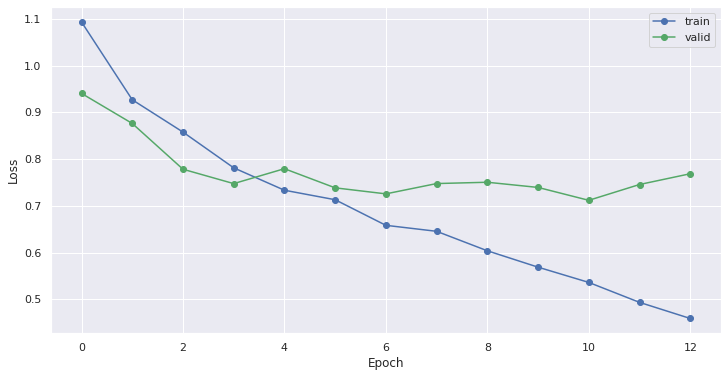

Training complete!


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Saving complete.
The new best learning rate is  0.0001
Processing epoch 1




Epoch:   2%|▏         | 1/50 [00:01<01:14,  1.51s/it]

Accuracy on train data:	0.5902
Batch dev loss: 0.7704368904232979
Accuracy on dev data:	0.7070
Processing epoch 2




Epoch:   4%|▍         | 2/50 [00:02<01:11,  1.49s/it]

Accuracy on train data:	0.7177
Batch dev loss: 0.7231406569480896
Accuracy on dev data:	0.7372
Processing epoch 3




Epoch:   6%|▌         | 3/50 [00:04<01:09,  1.47s/it]

Accuracy on train data:	0.7868
Batch dev loss: 0.7097437903285027
Accuracy on dev data:	0.7533
Processing epoch 4




Epoch:   8%|▊         | 4/50 [00:05<01:07,  1.46s/it]

Accuracy on train data:	0.8407
Batch dev loss: 0.77200997620821
Accuracy on dev data:	0.7398
Processing epoch 5




Epoch:  10%|█         | 5/50 [00:07<01:05,  1.46s/it]

Accuracy on train data:	0.8790
Batch dev loss: 0.8128433898091316
Accuracy on dev data:	0.7446
Processing epoch 6




Epoch:  12%|█▏        | 6/50 [00:08<01:03,  1.45s/it]

Accuracy on train data:	0.9176
Batch dev loss: 0.9040951505303383
Accuracy on dev data:	0.7266
Processing epoch 7




Epoch:  14%|█▍        | 7/50 [00:10<01:02,  1.45s/it]

Accuracy on train data:	0.9425
Batch dev loss: 1.0299174636602402
Accuracy on dev data:	0.7094
Processing epoch 8




Epoch:  16%|█▌        | 8/50 [00:11<01:00,  1.44s/it]

Accuracy on train data:	0.9583
Batch dev loss: 1.0447792708873749
Accuracy on dev data:	0.7242
Processing epoch 9




Epoch:  18%|█▊        | 9/50 [00:12<00:58,  1.44s/it]

Accuracy on train data:	0.9697
Batch dev loss: 1.3208679109811783
Accuracy on dev data:	0.7270
Processing epoch 10




Epoch:  20%|██        | 10/50 [00:14<00:57,  1.44s/it]

Accuracy on train data:	0.9816
Batch dev loss: 1.3600176125764847
Accuracy on dev data:	0.7216
Processing epoch 11




Epoch:  22%|██▏       | 11/50 [00:15<00:56,  1.44s/it]

Accuracy on train data:	0.9854
Batch dev loss: 1.4146204739809036
Accuracy on dev data:	0.7003
Processing epoch 12
Stopping early...
Training complete!


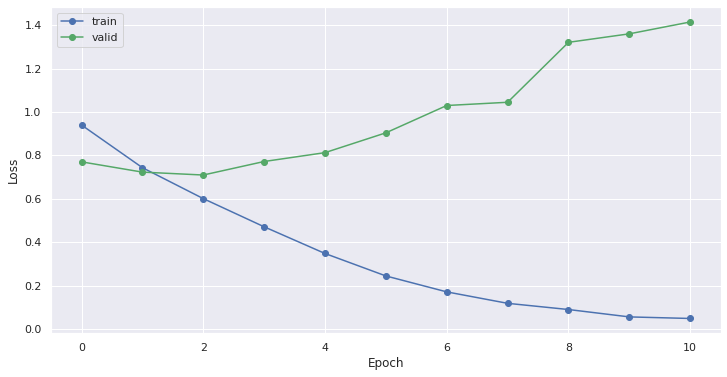




Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training complete!
Processing epoch 1





Epoch:   2%|▏         | 1/50 [00:01<01:10,  1.44s/it]

Accuracy on train data:	0.5338
Batch dev loss: 0.8577449098229408
Accuracy on dev data:	0.6169
Processing epoch 2





Epoch:   4%|▍         | 2/50 [00:02<01:09,  1.44s/it]

Accuracy on train data:	0.6738
Batch dev loss: 0.7544251680374146
Accuracy on dev data:	0.7398
Processing epoch 3





Epoch:   6%|▌         | 3/50 [00:04<01:07,  1.44s/it]

Accuracy on train data:	0.7925
Batch dev loss: 0.7694114595651627
Accuracy on dev data:	0.7052
Processing epoch 4





Epoch:   8%|▊         | 4/50 [00:05<01:06,  1.44s/it]

Accuracy on train data:	0.8635
Batch dev loss: 0.9026394262909889
Accuracy on dev data:	0.6994
Processing epoch 5





Epoch:  10%|█         | 5/50 [00:07<01:04,  1.44s/it]

Accuracy on train data:	0.9017
Batch dev loss: 1.247651919722557
Accuracy on dev data:	0.6593
Processing epoch 6





Epoch:  12%|█▏        | 6/50 [00:08<01:03,  1.45s/it]

Accuracy on train data:	0.9365
Batch dev loss: 1.1448708474636078
Accuracy on dev data:	0.6901
Processing epoch 7





Epoch:  14%|█▍        | 7/50 [00:10<01:02,  1.44s/it]

Accuracy on train data:	0.9489
Batch dev loss: 1.441055029630661
Accuracy on dev data:	0.6855
Processing epoch 8





Epoch:  16%|█▌        | 8/50 [00:11<01:00,  1.45s/it]

Accuracy on train data:	0.9675
Batch dev loss: 1.3343779295682907
Accuracy on dev data:	0.6983
Processing epoch 9





Epoch:  18%|█▊        | 9/50 [00:13<00:59,  1.45s/it]

Accuracy on train data:	0.9754
Batch dev loss: 1.4555358439683914
Accuracy on dev data:	0.7018
Processing epoch 10





Epoch:  20%|██        | 10/50 [00:14<00:57,  1.45s/it]

Accuracy on train data:	0.9834
Batch dev loss: 1.551140159368515
Accuracy on dev data:	0.7201
Processing epoch 11





Epoch:  22%|██▏       | 11/50 [00:15<00:56,  1.45s/it]

Accuracy on train data:	0.9869
Batch dev loss: 1.6886302083730698
Accuracy on dev data:	0.6851
Processing epoch 12
Stopping early...
Training complete!


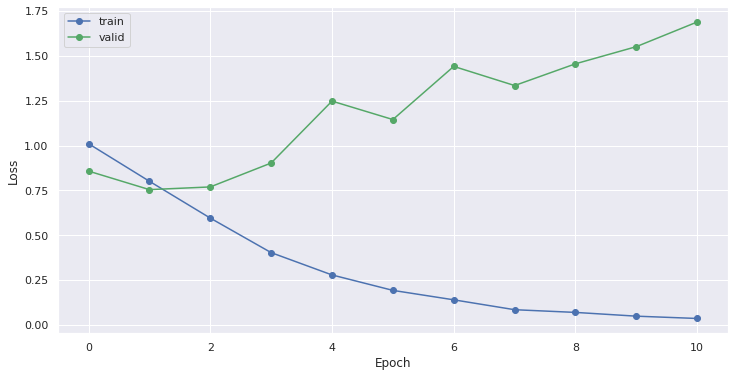





Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training complete!
Processing epoch 1






Epoch:   2%|▏         | 1/50 [00:01<01:09,  1.42s/it]

Accuracy on train data:	0.4534
Batch dev loss: 1.313795879483223
Accuracy on dev data:	0.5309
Processing epoch 2






Epoch:   4%|▍         | 2/50 [00:02<01:08,  1.42s/it]

Accuracy on train data:	0.4397
Batch dev loss: 2.309953451156616
Accuracy on dev data:	0.5309
Processing epoch 3






Epoch:   6%|▌         | 3/50 [00:04<01:06,  1.42s/it]

Accuracy on train data:	0.4302
Batch dev loss: 2.4691968709230423
Accuracy on dev data:	0.5309
Processing epoch 4






Epoch:   8%|▊         | 4/50 [00:05<01:05,  1.42s/it]

Accuracy on train data:	0.4424
Batch dev loss: 1.1779776439070702
Accuracy on dev data:	0.5338
Processing epoch 5






Epoch:  10%|█         | 5/50 [00:07<01:03,  1.42s/it]

Accuracy on train data:	0.4597
Batch dev loss: 1.1827946826815605
Accuracy on dev data:	0.5445
Processing epoch 6






Epoch:  12%|█▏        | 6/50 [00:08<01:02,  1.43s/it]

Accuracy on train data:	0.4896
Batch dev loss: 1.2532381564378738
Accuracy on dev data:	0.4665
Processing epoch 7






Epoch:  14%|█▍        | 7/50 [00:09<01:01,  1.43s/it]

Accuracy on train data:	0.4833
Batch dev loss: 1.1074981465935707
Accuracy on dev data:	0.5228
Processing epoch 8






Epoch:  16%|█▌        | 8/50 [00:11<00:59,  1.43s/it]

Accuracy on train data:	0.4855
Batch dev loss: 1.4775214567780495
Accuracy on dev data:	0.5293
Processing epoch 9






Epoch:  18%|█▊        | 9/50 [00:12<00:58,  1.43s/it]

Accuracy on train data:	0.5289
Batch dev loss: 1.032134436070919
Accuracy on dev data:	0.5916
Processing epoch 10






Epoch:  20%|██        | 10/50 [00:14<00:57,  1.43s/it]

Accuracy on train data:	0.5451
Batch dev loss: 1.2595281675457954
Accuracy on dev data:	0.4721
Processing epoch 11






Epoch:  22%|██▏       | 11/50 [00:15<00:55,  1.43s/it]

Accuracy on train data:	0.5116
Batch dev loss: 1.2490715309977531
Accuracy on dev data:	0.5769
Processing epoch 12






Epoch:  24%|██▍       | 12/50 [00:17<00:54,  1.43s/it]

Accuracy on train data:	0.4883
Batch dev loss: 1.5586867779493332
Accuracy on dev data:	0.5687
Processing epoch 13
Stopping early...
Training complete!


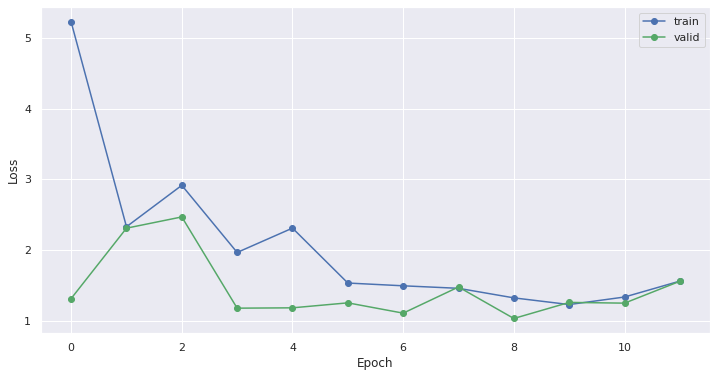






Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training complete!
Processing epoch 1







Epoch:   2%|▏         | 1/50 [00:01<01:08,  1.39s/it]

Accuracy on train data:	0.4338
Batch dev loss: 50.69872999191284
Accuracy on dev data:	0.5309
Processing epoch 2







Epoch:   4%|▍         | 2/50 [00:02<01:07,  1.40s/it]

Accuracy on train data:	0.4598
Batch dev loss: 11.897736489772797
Accuracy on dev data:	0.5012
Processing epoch 3







Epoch:   6%|▌         | 3/50 [00:04<01:05,  1.40s/it]

Accuracy on train data:	0.4776
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 4







Epoch:   8%|▊         | 4/50 [00:05<01:04,  1.39s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 5







Epoch:  10%|█         | 5/50 [00:06<01:02,  1.39s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 6







Epoch:  12%|█▏        | 6/50 [00:08<01:01,  1.39s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 7







Epoch:  14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 8







Epoch:  16%|█▌        | 8/50 [00:11<00:58,  1.39s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 9







Epoch:  18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 10







Epoch:  20%|██        | 10/50 [00:13<00:55,  1.39s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 11







Epoch:  22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 12
Stopping early...
Training complete!


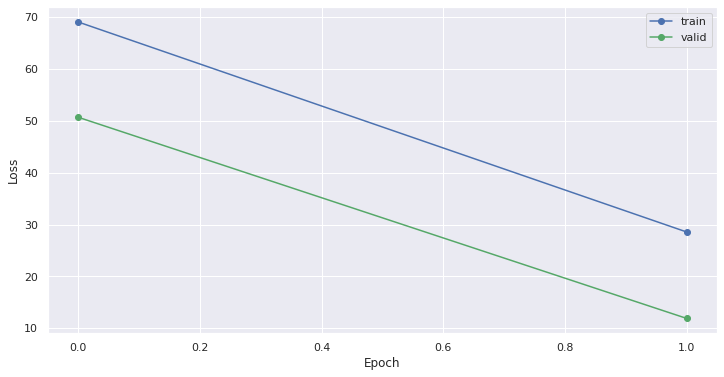

Training complete!


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
results_dict = {}
max_f1_value = 0

for i in LEARNING_RATES:
    # Initialize LSTM model
    model = LSTMClassifier(train_set, dev_set, test_set, PAD_ID, INPUT_DIM)  

    # Load pretrained vector
    model.embedding.weight.data.copy_(TEXT.vocab.vectors) 

    # Manually initialize UNK and PAD tokens as zero vectors (and NOT randomly as would be done otherwise)
    model.embedding.weight.data[UNK_ID] = torch.zeros(300)
    model.embedding.weight.data[PAD_ID] = torch.zeros(300)

    #model test
    train_dict = model.trainer(model, i, EARLY_STOPPING, N_EPOCHS) 
    (results_dict[i], labels, preds), ids = model.test(model)

    if results_dict[i]["f1"] >= max_f1_value: #only save best model
        max_f1_value = results_dict[i]["f1"]
        model_saver(model, "LSTM", OUTPUT_DIR, train_dict, labels, preds, results_dict[i])
        print("The new best learning rate is ", i)

# save complete training results
np.save(os.path.join(OUTPUT_DIR, "LSTM/LSTM_dogwhistle_total_training_results.npy"), results_dict)
df = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_dogwhistle_predictions.csv")
df["image_number"] = ids
df.to_csv("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_dogwhistle_predictions.csv")

In [ ]:
max_f1_value

0.7213470745509768

In [ ]:
results_dict

{0.0001: {'acc': 0.7549800796812749,
  'confusion_matrix': array([[231,  33,   0,   4],
         [ 38, 147,   0,   0],
         [  5,   7,   0,   0],
         [ 31,   5,   0,   1]]),
  'f1': 0.7213470745509768,
  'mcc': 0.5483049056479758,
  'precision': 0.7012304266540396,
  'recall': 0.7213470745509768},
 0.001: {'acc': 0.703187250996016,
  'confusion_matrix': array([[200,  41,   5,  22],
         [ 30, 144,   7,   4],
         [  4,   8,   0,   0],
         [ 20,   8,   0,   9]]),
  'f1': 0.7024802246159982,
  'mcc': 0.48601241931463696,
  'precision': 0.7033370940126806,
  'recall': 0.7024802246159982},
 0.01: {'acc': 0.6852589641434262,
  'confusion_matrix': array([[187,  56,   4,  21],
         [ 28, 145,   5,   7],
         [  5,   6,   1,   0],
         [ 19,   6,   1,  11]]),
  'f1': 0.6857554821056109,
  'mcc': 0.46293135542411157,
  'precision': 0.6915461159999889,
  'recall': 0.6857554821056109},
 0.1: {'acc': 0.5637450199203188,
  'confusion_matrix': array([[209,  59,   0,

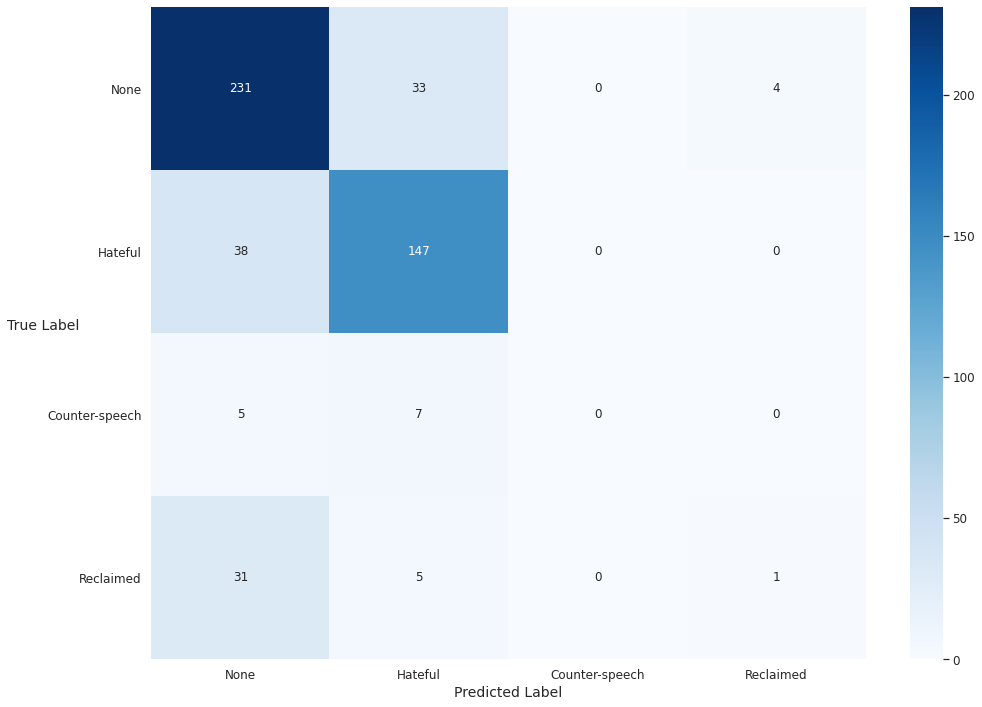

In [ ]:
X_TICK_LABELS = ["None", "Hateful", "Counter-speech", "Reclaimed"]
Y_TICK_LABELS = ["None", "Hateful", "Counter-speech", "Reclaimed"]
COLOR = "Blues"
SAVE_NAME = "/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_cm_dogwhistle.png"
CM = np.load("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_dogwhistle_test_results.npy", allow_pickle=True)

confusion_matrix_plotter(CM, SAVE_NAME, X_TICK_LABELS, Y_TICK_LABELS, COLOR)

### Investigating how datasize effects performance

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Processing epoch 1


Epoch:   2%|▏         | 1/50 [00:01<01:14,  1.52s/it]

Accuracy on train data:	0.5312
Batch dev loss: 0.9419197589159012
Accuracy on dev data:	0.6044
Processing epoch 2


Epoch:   4%|▍         | 2/50 [00:02<01:11,  1.50s/it]

Accuracy on train data:	0.5951
Batch dev loss: 0.8883729353547096
Accuracy on dev data:	0.6239
Processing epoch 3


Epoch:   6%|▌         | 3/50 [00:04<01:10,  1.49s/it]

Accuracy on train data:	0.6523
Batch dev loss: 0.7834524065256119
Accuracy on dev data:	0.7163
Processing epoch 4


Epoch:   8%|▊         | 4/50 [00:05<01:08,  1.48s/it]

Accuracy on train data:	0.6836
Batch dev loss: 0.7567043676972389
Accuracy on dev data:	0.7037
Processing epoch 5


Epoch:  10%|█         | 5/50 [00:07<01:06,  1.48s/it]

Accuracy on train data:	0.7151
Batch dev loss: 0.7270165234804153
Accuracy on dev data:	0.7305
Processing epoch 6


Epoch:  12%|█▏        | 6/50 [00:08<01:04,  1.47s/it]

Accuracy on train data:	0.7372
Batch dev loss: 0.7298048585653305
Accuracy on dev data:	0.7154
Processing epoch 7


Epoch:  14%|█▍        | 7/50 [00:10<01:03,  1.47s/it]

Accuracy on train data:	0.7369
Batch dev loss: 0.7061617821455002
Accuracy on dev data:	0.7305
Processing epoch 8


Epoch:  16%|█▌        | 8/50 [00:11<01:01,  1.47s/it]

Accuracy on train data:	0.7599
Batch dev loss: 0.7209761887788773
Accuracy on dev data:	0.7387
Processing epoch 9


Epoch:  18%|█▊        | 9/50 [00:13<00:59,  1.46s/it]

Accuracy on train data:	0.7722
Batch dev loss: 0.739792212843895
Accuracy on dev data:	0.7257
Processing epoch 10


Epoch:  20%|██        | 10/50 [00:14<00:58,  1.46s/it]

Accuracy on train data:	0.7845
Batch dev loss: 0.7229087874293327
Accuracy on dev data:	0.7368
Processing epoch 11


Epoch:  22%|██▏       | 11/50 [00:16<00:56,  1.46s/it]

Accuracy on train data:	0.7948
Batch dev loss: 0.6934195980429649
Accuracy on dev data:	0.7568
Processing epoch 12


Epoch:  24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

Accuracy on train data:	0.8136
Batch dev loss: 0.6803746521472931
Accuracy on dev data:	0.7524
Processing epoch 13


Epoch:  26%|██▌       | 13/50 [00:19<00:54,  1.46s/it]

Accuracy on train data:	0.8251
Batch dev loss: 0.7208217680454254
Accuracy on dev data:	0.7398
Processing epoch 14
Stopping early...
Training complete!


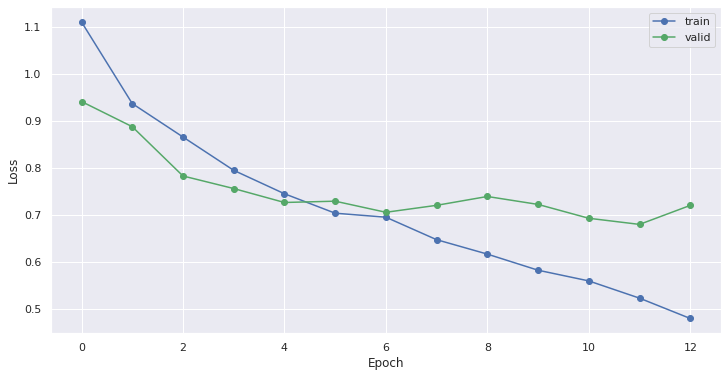

Training complete!
{'mcc': 0.0, 'acc': 0.8571428571428571, 'confusion_matrix': array([[  0,   0],
       [ 17, 102]]), 'precision': 1.0, 'recall': 0.923076923076923, 'f1': 0.923076923076923}
{'mcc': 0.0, 'acc': 0.7878787878787878, 'confusion_matrix': array([[ 0,  0],
       [14, 52]]), 'precision': 1.0, 'recall': 0.8813559322033898, 'f1': 0.8813559322033898}
{'mcc': 0.06830955848266018, 'acc': 0.6782334384858044, 'confusion_matrix': array([[214,  52,   0,   2],
       [  0,   0,   0,   0],
       [  4,   8,   0,   0],
       [ 28,   8,   0,   1]]), 'precision': 0.7743581852222308, 'recall': 0.7098092525991482, 'f1': 0.7098092525991482}
{3500: 0.7018248108483498}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
NOMARLIZE_LIST = ['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number']
ANNOTATE_LIST = ['hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored']


f1_scores = {}

for i in [3500]: #[2000, 2500, 3000]:

    # Load data
    train = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Train/dog_whistle_train.csv", encoding='utf-8')
    train = train[:i]
    dev = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Validation/dog_whistle_dev.csv", encoding='utf-8')
    test = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Test/dog_whistle_test.csv", encoding='utf-8')

    # Combine Image and Tweet Text
    train["text"] = combine_text(train)
    dev["text"] = combine_text(dev)
    test["text"] = combine_text(test)

    # Clean data
    train["text"] = clean_text(train["text"], NOMARLIZE_LIST, ANNOTATE_LIST)
    dev["text"] = clean_text(dev["text"], NOMARLIZE_LIST, ANNOTATE_LIST)
    test["text"] = clean_text(test["text"], NOMARLIZE_LIST, ANNOTATE_LIST)

    # Rename label column 
    train["labels"] = train["Unimodal_text_numeric"]
    dev["labels"] = dev["Unimodal_text_numeric"]
    test["labels"] = test["Primary_numeric_gt"]

    # Subset with necessary data
    train_use = train[["text", "labels", "image_number"]]
    dev_use = dev[["text", "labels", "image_number"]]
    test_use = test[["text", "labels", "image_number"]]

    # Define fields
    TEXT = Field(sequential=True, tokenize="spacy", include_lengths=True) 
    LABEL = Field(sequential=False, use_vocab=False)
    IDS = Field(sequential=False, use_vocab=False)
    fields = [('text', TEXT), ('labels', LABEL), ('image_number', IDS)] 

    # Create datasets
    train_set = Dataset([Example.fromlist(i, fields) for i in train_use.values.tolist()], fields=fields)
    dev_set = Dataset([Example.fromlist(i, fields) for i in dev_use.values.tolist()], fields=fields)
    test_set = Dataset([Example.fromlist(i, fields) for i in test_use.values.tolist()], fields=fields)

    # Get training words and pretrained vectors (training words without vectors are initialized randomly)
    TEXT.build_vocab(train_set, vectors='fasttext.simple.300d', unk_init=torch.Tensor.normal_)

    INPUT_DIM = len(TEXT.vocab)
    PAD_ID = TEXT.vocab.stoi[TEXT.pad_token]
    UNK_ID = TEXT.vocab.stoi[TEXT.unk_token]

    # Initialize LSTM model
    model = LSTMClassifier(train_set, dev_set, test_set, PAD_ID, INPUT_DIM)  

    # Load pretrained vector
    model.embedding.weight.data.copy_(TEXT.vocab.vectors) 

    # Manually initialize UNK and PAD tokens as zero vectors (and NOT randomly as would be done otherwise)
    model.embedding.weight.data[UNK_ID] = torch.zeros(300)
    model.embedding.weight.data[PAD_ID] = torch.zeros(300)

    #model test
    train_dict = model.trainer(model, 0.0001, {"patience": 10, "delta": 0.01}, 50) 
    (results_dict, _, preds), ids = model.test(model)

    df = pd.DataFrame([preds, ids]).T
    df = df.rename(columns= {0: "Predictions", 1: "image_number"})

    f1_scores[i] = results_dict["f1"]


    test = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Test/dog_whistle_test.csv", encoding='utf-8')
    test = pd.merge(test, df, on="image_number")


    dw_df = test[test["Strategies_numeric_gt"] == 2]
    dw_results, _, _ = metrics(dw_df["Primary_numeric_gt"], dw_df["Predictions"])
    print(dw_results)

    explicit_df = test[test["Strategies_numeric_gt"] == 1]
    explicit_results, _, _ = metrics(explicit_df["Primary_numeric_gt"], explicit_df["Predictions"])
    print(explicit_results)

    none_df = test[test["Strategies_numeric_gt"] == 0]
    none_results, _, _ = metrics(none_df["Primary_numeric_gt"], none_df["Predictions"])
    print(none_results)


print(f1_scores)
#np.save(os.path.join("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_datasize_results.npy"), f1_scores)